In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from functools import singledispatch, singledispatchmethod, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric import nn as gnn
from torch_geometric.nn.conv import GCNConv, SimpleConv, SGConv
from tqdm import tqdm
from asterism.core import buildmethod, checkmethod, Asterism, AsterismSpatial
from asterism.models.lda import GibbsLDA
from asterism.models.ntm import ATLAS, NTM, RSB
from asterism.utils import get_kwargs, kmeans, normalize, relabel, to_list
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACTS, NORMS, OPTIMS, Encoder, MLP, RNN
from asterism.utils.plots import show_comparison, show_dataset
from asterism.utils.sugar import attrmethod

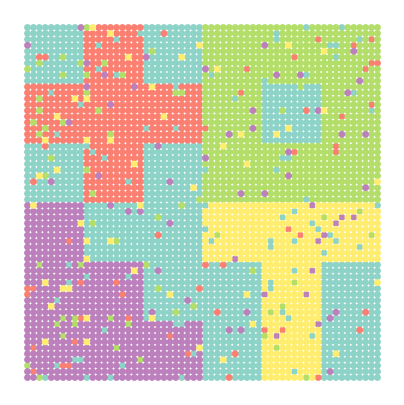

In [2]:
data, locs, labels = make_dataset(mix=.1)
show_dataset(locs, labels)

In [3]:
def _build_docs(locs, n_docs=None, doc_size=4, state=None):
    sections, docs = np.unique(locs[:, 0]), []    
    state = check_random_state(state)

    for s in sections if locs.shape[1] > 2 else locs[None, :, 0]:
        n_samples = (s_mask := locs[:, 0] == s).sum()
        s_docs = n_docs if n_docs is not None else n_samples//4
        s_idx = state.permutation(n_samples)[:s_docs]
        s_locs = locs[s_mask, -2:][s_idx]
        s_dists = cdist(s_locs, s_locs, 'sqeuclidean')
        s_vars = np.sort(s_dists, -1)[:, doc_size]
        docs.append(np.concat([s_locs, s_vars[:, None]], -1))
    
    docs = np.concat(docs, 0)

    return docs

def _build_data(X, locs, data_size=4):
    sections, data = np.unique(locs[:, 0]), []

    for s in sections if locs.shape[-1] > 2 else locs[None, :, 0]:
        s_locs = locs[s_mask := locs[:, 0] == s, -2:]
        s_dists = cdist(s_locs, s_locs, 'sqeuclidean')
        s_vars = np.sort(s_dists, -1)[:, data_size]
        gauss = np.exp(-s_dists/(2*s_vars))/(np.sqrt(2*np.pi*s_vars))
        data.append(gauss@X[s_mask])

    data = np.concat(data, 0)

    return data

class GibbsSLDA(AsterismSpatial):
    def __init__(self, n_topics=3, *, n_docs=None, doc_size=4, data_size=4, vocab_size=32, dt_prior=1., tw_prior=1., desc='SLDA', seed=None):
        super().__init__(desc, seed)

        self.n_topics = n_topics
        self.n_docs = n_docs
        self.doc_size = doc_size
        self.data_size = data_size
        self.vocab_size = vocab_size
        self.dt_prior = dt_prior
        self.tw_prior = tw_prior

        self._n_steps = 100

    def _build_docs(self, locs):
        docs = _build_docs(locs, self.n_docs, self.doc_size, self._state)

        return docs
    
    def _build_data(self, X, locs):
        data = _build_data(X, locs, self.data_size)

        return data

    def _build(self, X, locs):
        self._locs = np.concat([np.zeros([locs.shape[0], 3 - locs.shape[1]]), locs], -1)
        self._docs, data = self._build_docs(self._locs), self._build_data(X, self._locs)
        self.words_, n_docs = kmeans(data, self.vocab_size, verbosity=0), self._docs.shape[0]
        doc_range, topic_range = np.arange(n_docs)[None].T, np.arange(self.n_topics)[None].T
        self.docs_, self.topics_ = np.zeros((2, self._n_steps, X.shape[0]), dtype=np.int32)
        self.topics_[-1:] = self._state.choice(self.n_topics, X.shape[0])
        self.dt_post_ = (self.docs_[-1] == doc_range)@np.eye(self.n_topics)[self.topics_[-1]]
        self.tw_post_ = (self.topics_[-1] == topic_range)@np.eye(self.vocab_size)[self.words_]

        return self
    
    def _query(self, idx):
        loc = self._locs[idx]
        doc = self.docs_[self._step_n - 1, idx]
        topic = self.topics_[self._step_n - 1, idx]
        word = self.words_[idx]

        return loc, doc, topic, word
    
    def _decrement(self, doc, topic, word, return_posts=False):
        self.dt_post_[doc, topic] -= 1
        self.tw_post_[topic, word] -= 1

        if return_posts:
            return self.dt_post_, self.tw_post_
        return self
    
    def _increment(self, doc, topic, word, return_posts=False):
        self.dt_post_[doc, topic] += 1
        self.tw_post_[topic, word] += 1

        if return_posts:
            return self.dt_post_, self.tw_post_
        return self
    
    def _sample_doc(self, loc, topic, return_probs=False):
        mask = self._docs[:, 0] == loc[0]
        cdists = cdist(loc[None, 1:], self._docs[mask, 1:3], 'sqeuclidean')[0]
        wd_probs = np.exp(-cdists/(2*self._docs[mask, -1]))
        dt_probs = self.dt_post_[mask, topic] + self.dt_prior
        dt_probs /= (self.dt_post_[mask] + self.dt_prior).sum(-1)
        probs = normalize(wd_probs*dt_probs)
        doc = self._state.choice(mask.sum(), p=probs)

        if return_probs:
            return doc, probs
        return doc

    def _sample_topic(self, doc, word, return_probs=False):
        dt_probs = normalize(self.dt_post_[doc] + self.dt_prior)
        tw_probs = self.tw_post_[:, word] + self.tw_prior
        tw_probs /= (self.tw_post_ + self.tw_prior).sum(-1)
        probs = normalize(dt_probs*tw_probs)
        topic = self._state.choice(self.n_topics, p=probs)

        if return_probs:
            return topic, probs
        return topic

    def _step(self):
        idx, likelihood = self._state.permutation(self.words_.shape[0]), 0

        for i in idx:
            loc, doc, topic, word = self._query(i)
            self._decrement(doc, topic, word)
            new_doc, doc_probs = self._sample_doc(loc, topic, return_probs=True)
            new_topic, topic_probs = self._sample_topic(doc, word, return_probs=True)
            self._increment(new_doc, new_topic, word)
            self.docs_[self._step_n, i] = new_doc
            self.topics_[self._step_n, i] = new_topic
            likelihood += doc_probs[new_doc] + topic_probs[new_topic]

        return likelihood

    def _predict(self):
        burn_in = self._n_steps//2
        topics = mode(self.topics_[burn_in:]).mode

        return topics

SLDA: 100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


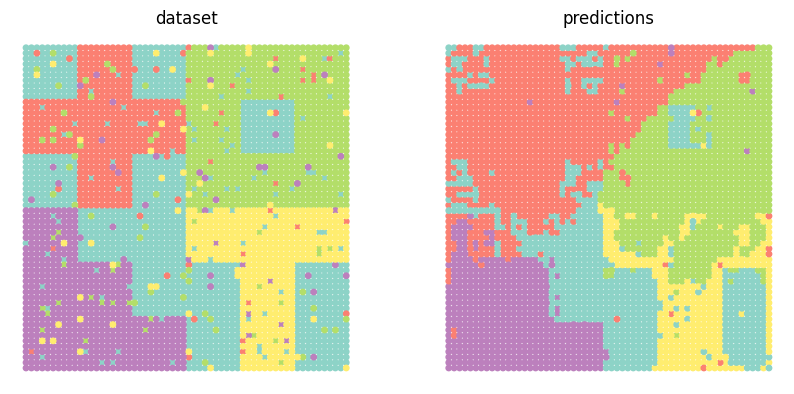

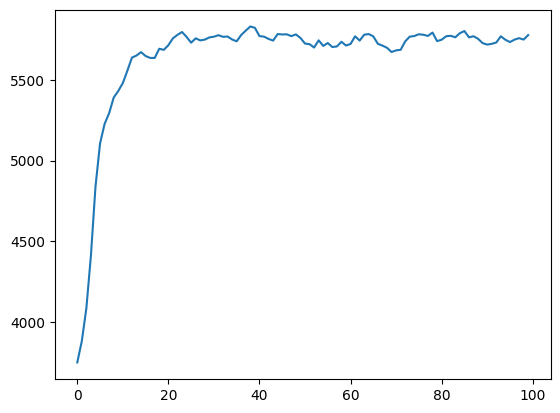

In [8]:
model = GibbsSLDA(5)
data, locs, labels = make_dataset(mix=.1)
topics = model.fit_predict(data, locs, labels)
show_comparison(locs, labels, topics)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

In [67]:
model._docs.shape

(900, 3)

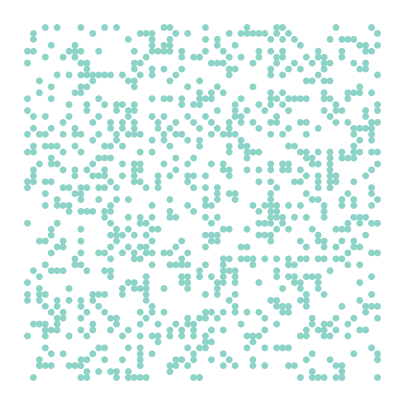

In [68]:
show_dataset(model._docs[:, :-1])

In [11]:
model._locs

array([[ 0., 30.],
       [ 0., 31.],
       [ 0., 32.],
       ...,
       [59., 27.],
       [59., 28.],
       [28., 59.]], shape=(3600, 2))

In [62]:
model.tw_post_.shape

(3, 32)

In [63]:
model.dt_post_.shape

(900, 3)

In [3]:
model = GibbsLDA()
model._build(data)

,n_topics,3
,doc_size,32
,vocab_size,32
,dt_prior,1.0
,tw_prior,1.0
,desc,'LDA'
,seed,None


In [4]:
model.docs_

array([[ 0,  0,  0, ...,  1,  0,  6],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  4,  2],
       ...,
       [31, 31, 31, ..., 31, 30, 31],
       [31, 31, 30, ..., 31, 31, 31],
       [30, 30, 31, ..., 29, 31, 31]], shape=(3600, 32), dtype=int32)

In [5]:
model.words_

array([ 0,  0,  0, ..., 29, 31, 31], shape=(115200,), dtype=int32)

KMeans: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


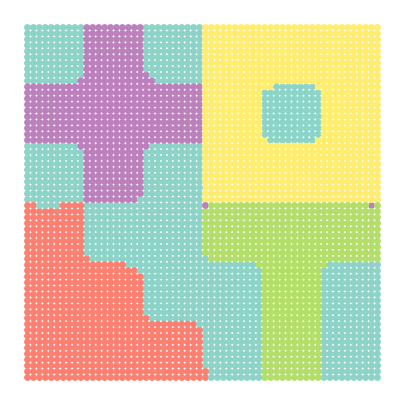

In [44]:
X = make_data(data, locs)
topics = kmeans(X, 5)
show_dataset(locs, topics)

In [ ]:
kmeans(X)

array([[  3.73229817,  22.19058241,  16.4535592 , ...,   6.72920714,
        -17.31835408,  21.09749606],
       [ 13.42915884,  21.39379416,  17.43995721, ...,  15.12680986,
        -21.49979512,  21.74986028],
       [ 17.46943326,  22.15255556,  18.1120707 , ...,  17.94234705,
        -23.01131492,  19.21477787],
       ...,
       [ 13.71711604, -16.05283169, -13.88112462, ...,  16.63330569,
        -19.8544145 , -21.32340036],
       [ 13.60787816, -18.25942268, -12.73228811, ...,  14.41169025,
        -24.57981238, -20.78932036],
       [  9.72820505, -18.74180464,  -5.19094273, ...,   2.98445125,
        -26.73018075, -20.28344156]], shape=(3600, 100))

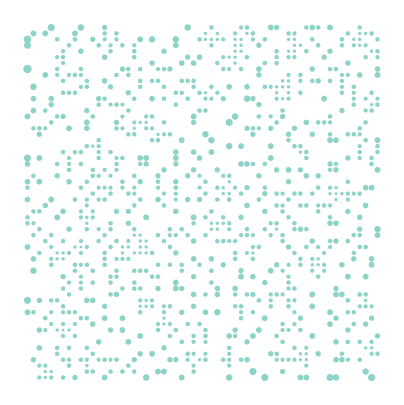

In [16]:
def distribute(locs, n_documents=None, scale=1., n_neighbors=4):
    sections = np.unique(locs[:, 0])
    documents = []

    for s in sections:
        mask = locs[:, 0] == s

        if n_documents is None:
            n_documents = mask.sum()//4

        idx = np.random.permutation(mask.sum())[:n_documents]
        doc_locs = locs[mask, :3][idx]
        proximity = cdist(doc_locs[:, 1:], doc_locs[:, 1:], 'sqeuclidean')
        variance = scale*np.sort(proximity, -1)[:, n_neighbors]
        documents.append(np.hstack([doc_locs, variance[None].T]))

    documents = np.vstack(documents)

    return documents

docs = distribute(locs)
show_dataset(docs[:, :-1], size=docs[:, -1])